In [2]:
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['DejaVu Sans'],
    'mathtext.fontset': 'cm',
    'text.usetex': False,
    'font.size': 12,
    'axes.labelsize': 13, 'axes.titlesize': 14, 'legend.fontsize': 10,
    'xtick.labelsize': 10, 'ytick.labelsize': 10,
    'axes.spines.top': False, 'axes.spines.right': False,
    'axes.grid': True, 'grid.color': '#DDDDDD', 'grid.linestyle': '-', 'grid.alpha': 0.5,
    'figure.facecolor': 'white', 'axes.facecolor': 'white',
    'savefig.bbox': 'tight', 'savefig.pad_inches': 0.05,
})

### Erdős Minimum Overlap Problem

In [ ]:
def verify_sequence(sequence: list[float]):
    if not all(0 <= val <= 1 for val in sequence):
        raise AssertionError("All values must be between 0 and 1.")
    if not np.sum(sequence) == len(sequence) / 2.0:
        raise AssertionError(f"Sum is {np.sum(sequence)} but should be {len(sequence) / 2.0}.")

def compute_upper_bound(sequence: list[float]) -> float:
    convolution_values = np.correlate(np.array(sequence), 1 - np.array(sequence), mode='full')
    return np.max(convolution_values) / len(sequence) * 2

def plot_erdos_step(ax, seq, title, color):
    n = len(seq)
    edges = np.linspace(-0.25, 0.25, n + 1)
    ax.step(edges[:-1], seq, where='post', color=color, linewidth=1.8)
    ax.set_xlabel('')
    #ax.set_ylabel(r"$f$")
    ax.set_ylabel("")
    ax.set_title(title)
    ax.set_xlim([-0.28, 0.28])
    ax.set_ylim([-0.05, max(seq) * 1.15])
    ax.set_xticks([])
    ax.set_yticks([])
    bound = compute_upper_bound(seq)
    textstr = f"{n}-piece function\n$c \\leq {np.ceil(bound * 1e6) / 1e6:.6f}$"
    props = dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='#888888', alpha=0.9)
    ax.text(0.03, 0.92, textstr, transform=ax.transAxes, fontsize=11,
            verticalalignment='top', horizontalalignment='left', bbox=props)

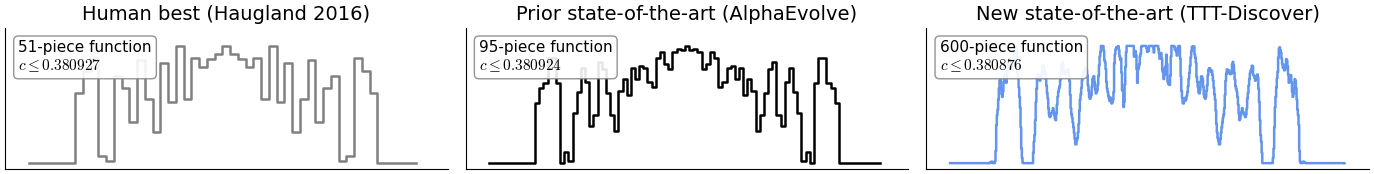

In [16]:
from erdos_data import ae_v2_erdos, ttt_best as ttt_best_erdos
from human_best_erdos import haugland_full

ttt_best_erdos_construction = ttt_best_erdos()
verify_sequence(ae_v2_erdos)
verify_sequence(ttt_best_erdos_construction)
verify_sequence(haugland_full)

fig, axes = plt.subplots(1, 3, figsize=(14, 2))
plot_erdos_step(axes[0], haugland_full, "Human best (Haugland 2016)", color='gray')
plot_erdos_step(axes[1], ae_v2_erdos, "Prior state-of-the-art (AlphaEvolve)", color='black')
plot_erdos_step(axes[2], ttt_best_erdos_construction, "New state-of-the-art (TTT-Discover)", color='#6495ED')
plt.tight_layout()
plt.savefig("erdos_comparison.pdf")
plt.show()

In [17]:
print("Human best (Haugland 2016):", len(haugland_full), compute_upper_bound(haugland_full))
print("AlphaEvolve:", len(ae_v2_erdos), compute_upper_bound(ae_v2_erdos))
print("TTT-Discover:", len(ttt_best_erdos_construction), compute_upper_bound(ttt_best_erdos_construction))

Human best (Haugland 2016): 51 0.38092685343308713
AlphaEvolve: 95 0.38092303510845016
TTT-Discover: 600 0.3808753232177187


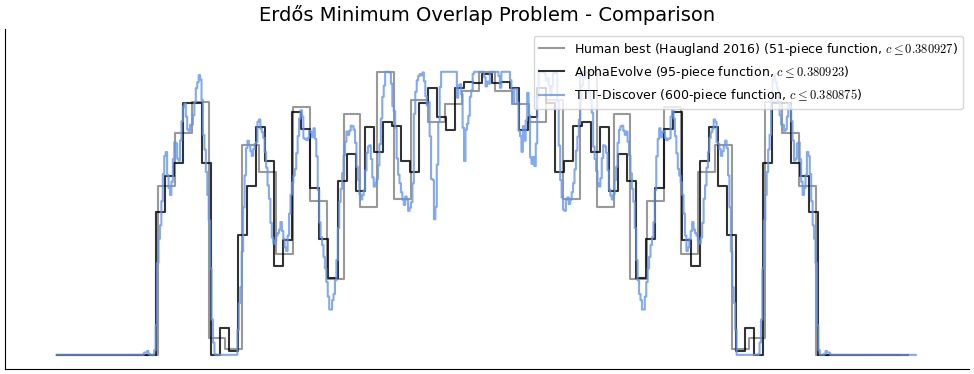

In [15]:
def plot_erdos_overlay(ax, sequences, labels, colors):
    for seq, label, color in zip(sequences, labels, colors):
        n = len(seq)
        edges = np.linspace(-0.25, 0.25, n + 1)
        bound = compute_upper_bound(seq)
        ax.step(edges[:-1], seq, where='post', color=color, linewidth=1.5, alpha=0.8,
                label=f'{label} ({n}-piece function, $c \\leq {bound:.6f}$)')
    ax.set_xlabel('')
    ax.set_ylabel("")
    ax.set_title("Erdős Minimum Overlap Problem - Comparison")
    ax.set_xlim([-0.28, 0.28])
    ax.set_ylim([-0.05, 1.15])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.legend(loc='upper right', fontsize=9)

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
plot_erdos_overlay(
    ax,
    [haugland_full, ae_v2_erdos, ttt_best_erdos_construction],
    ['Human best (Haugland 2016)', 'AlphaEvolve', 'TTT-Discover'],
    ['gray', 'black', '#6495ED']
)
plt.tight_layout()
plt.savefig("erdos_overlay.pdf")
plt.show()


### First Autocorrelation Inequality

In [6]:
def evaluate_ac1(sequence: list[float]) -> float:
    if not isinstance(sequence, list) or not sequence:
        return np.inf
    for x in sequence:
        if isinstance(x, bool) or not isinstance(x, (int, float)) or np.isnan(x) or np.isinf(x):
            return np.inf
    sequence = [min(1000.0, max(0, float(x))) for x in sequence]
    n = len(sequence)
    b_sequence = np.convolve(sequence, sequence)
    sum_a = np.sum(sequence)
    if sum_a < 0.01:
        return np.inf
    return float(2 * n * max(b_sequence) / (sum_a**2))

def normalize(seq):
    seq = np.array(seq)
    return (seq - seq.min()) / (seq.max() - seq.min())

def plot_ac1_step(ax, seq, title, color):
    n = len(seq)
    seq_norm = normalize(seq)
    edges = np.linspace(-0.25, 0.25, n + 1)
    ax.step(edges[:-1], seq_norm, where='post', color=color, linewidth=1.5)
    ax.set_xlabel('')
    ax.set_ylabel("")
    #ax.set_ylabel(r"$f$ (norm.)")
    ax.set_title(title)
    ax.set_xlim([-0.28, 0.28])
    ax.set_ylim([-0.05, 1.15])
    ax.set_xticks([])
    ax.set_yticks([])
    score = evaluate_ac1(list(seq))
    textstr = f"$C_1 \\leq {np.ceil(score * 1e5) / 1e5:.5f}$"
    props = dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='#888888', alpha=0.9)
    ax.text(0.03, 0.92, textstr, transform=ax.transAxes, fontsize=11,
            verticalalignment='top', horizontalalignment='left', bbox=props)

def plot_ac1_overlay(ax, seq1, seq2, title, label1, label2):
    """Plot AlphaEvolve in black, then only show diffs for ThetaEvolve in green."""
    n = len(seq1)
    seq1_norm = normalize(seq1)
    seq2_norm = normalize(seq2)
    edges = np.linspace(-0.25, 0.25, n + 1)
    # Plot AlphaEvolve fully in black
    ax.step(edges[:-1], seq1_norm, where='post', color='black', linewidth=1.5)
    # Plot ThetaEvolve only where different, in green
    diff_threshold = 0.001
    for i in range(n):
        if abs(seq1_norm[i] - seq2_norm[i]) > diff_threshold:
            ax.hlines(seq2_norm[i], edges[i], edges[i+1], colors='#E63946', linewidth=1.5)
    ax.set_xlabel('')
    #ax.set_ylabel(r"$f$ (norm.)")
    ax.set_ylabel("")
    ax.set_title(title)
    ax.set_xlim([-0.28, 0.28])
    ax.set_ylim([-0.05, 1.15])
    ax.set_xticks([])
    ax.set_yticks([])
    # Put bounds in legend
    score1, score2 = evaluate_ac1(list(seq1)), evaluate_ac1(list(seq2))
    ax.plot([], [], color='black', linewidth=1.5, label=f'{label1}: $C_1 \\leq {np.ceil(score1 * 1e5) / 1e5:.5f}$')
    ax.plot([], [], color='#E63946', linewidth=1.5, label=f'{label2}: $C_1 \\leq {np.ceil(score2 * 1e5) / 1e5:.5f}$')
    ax.legend(loc='upper left', fontsize=9)

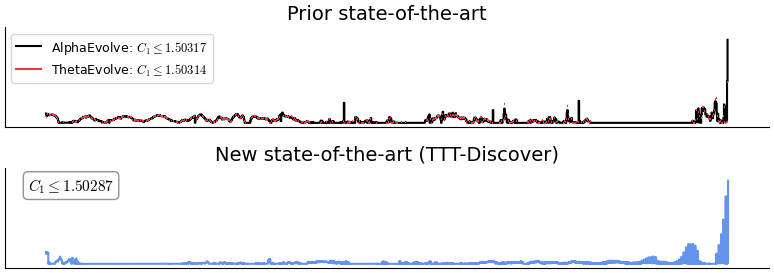

In [7]:
from ac1_data import alphaevolve_v2_150316, thetaevolve_150313, ttt_best as ttt_best_ac1

ae_ac1 = alphaevolve_v2_150316
theta_ac1 = thetaevolve_150313
ttt_ac1 = ttt_best_ac1()

fig, axes = plt.subplots(2, 1, figsize=(8, 3))
plot_ac1_overlay(axes[0], ae_ac1, theta_ac1, "Prior state-of-the-art", 'AlphaEvolve', 'ThetaEvolve')
plot_ac1_step(axes[1], ttt_ac1, "New state-of-the-art (TTT-Discover)", color='#6495ED')
plt.tight_layout()
plt.savefig("ac1_comparison.pdf")
plt.show()

In [8]:
len(ttt_ac1), len(theta_ac1), len(ae_ac1)

(30000, 1319, 1319)

In [9]:
from ac1_data import alphaevolve_v2_150316, thetaevolve_150313, ae_v1, prev_human, thetaevolve_wo_rl
print(evaluate_ac1(ae_ac1))
print(evaluate_ac1(prev_human))
print(evaluate_ac1(alphaevolve_v2_150316))
print(evaluate_ac1(ae_v1))
print(evaluate_ac1(ttt_ac1))
print(evaluate_ac1(thetaevolve_wo_rl))


1.503163554681561
1.5097201507458793
1.503163554681561
1.5052939684401607
1.5028628982558263
1.5068026727114598


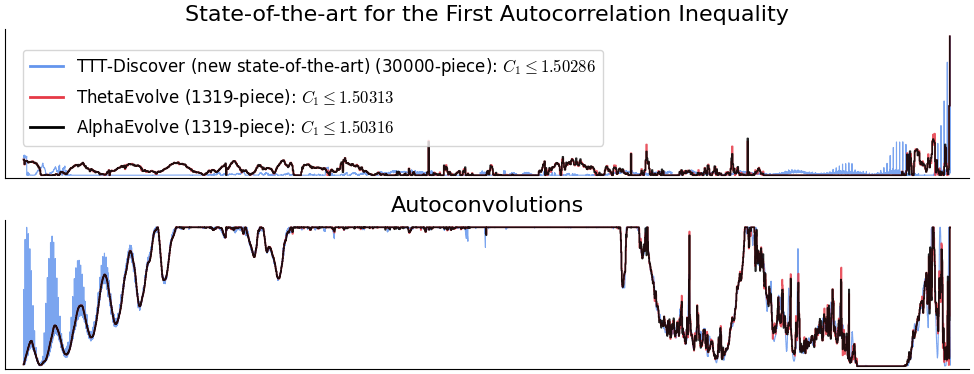

In [10]:
from ac1_data import prev_human

def plot_ac1_all_overlay(ax, sequences, title):
    """Overlay all sequences on the same plot."""
    for seq, color, label, lw in sequences:
        seq_norm = normalize(seq)
        n = len(seq)
        edges = np.linspace(-0.25, 0.25, n + 1)
        ax.step(edges[:-1], seq_norm, where='post', color=color, linewidth=lw, alpha=0.85)
        score = evaluate_ac1(list(seq))
        ax.plot([], [], color=color, linewidth=2, label=f'{label} ({n}-piece): $C_1 \\leq {score:.5f}$')
    
    ax.set_xlabel('')
    ax.set_ylabel("")
    ax.set_title(title, fontsize=16)
    ax.set_xlim([-0.26, 0.26])
    ax.set_ylim([-0.02, 1.05])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.legend(loc='upper left', fontsize=12, bbox_to_anchor=(0.01, 0.92))

def plot_autocorr_overlay(ax, sequences, title):
    """Overlay autoconvolutions of all sequences on the same plot."""
    for seq, color, label, lw in sequences:
        autocorr = np.convolve(seq, seq)
        autocorr_norm = normalize(autocorr)
        if 'TTT' in label:  # Flip TTT-Discover
            autocorr_norm = autocorr_norm[::-1]
        n = len(autocorr)
        edges = np.linspace(-0.5, 0.5, n + 1)
        ax.step(edges[:-1], autocorr_norm, where='post', color=color, linewidth=lw, alpha=0.85)
    
    ax.set_xlabel('')
    ax.set_ylabel("")
    ax.set_title(title, fontsize=16)
    ax.set_xlim([-0.52, 0.52])
    ax.set_ylim([-0.02, 1.05])
    ax.set_xticks([])
    ax.set_yticks([])

# Order: TTT first (background), then others on top
sequences = [
    (ttt_ac1, '#6495ED', 'TTT-Discover (new state-of-the-art)', 0.8),
    #(prev_human, '#2CA02C', 'Human best', 1.2),
    (theta_ac1, '#E63946', 'ThetaEvolve', 1.2),
    (ae_ac1, 'black', 'AlphaEvolve', 1.2),
]

fig, axes = plt.subplots(2, 1, figsize=(10, 4))
plot_ac1_all_overlay(axes[0], sequences, "State-of-the-art for the First Autocorrelation Inequality")
plot_autocorr_overlay(axes[1], sequences, "Autoconvolutions")
plt.tight_layout()
plt.savefig("ac1_overlay.pdf")
plt.show()